In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import pycocotools.mask as maskapi
import pickle
import random
from PIL import Image
random.seed(234)

In [2]:
dataDir='../coco/'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=31.30s)
creating index...
index created!
118287


In [4]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [5]:
# get all images containing person,
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds.sort()
print len(imgIds)
print imgIds[:10]

64115
[36, 49, 61, 74, 77, 86, 109, 110, 113, 127]


In [6]:
def get_mask(imgId, idx=0):
    """Get mask for idx'th person in this imgId."""
    img = coco.loadImgs(imgId)[0]
    I = io.imread(img['coco_url'])
    # plt.imshow(I); plt.axis('off')

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=False)
    anns = coco.loadAnns(annIds)
    if idx >= len(anns):
        return None, None

    ann = anns[idx]
    bb = ann['bbox']
    x1, x2, y1, y2 = [int(bb[0]), int(bb[0]+bb[2]), int(bb[1]), int(bb[1]+bb[3])]

    mask=coco.annToMask(ann)
    
    if len(I.shape) < 3:
        # Let's not worry about black and white images.
        return None, None
    img = I[y1:y2, x1:x2, :]
    mask = np.array(mask[y1:y2, x1:x2])
    return img, mask 

def get_iou(mask1, mask2):
    """Get IOU of two binary segmentation masks."""
    rle1 = maskapi.encode(np.asfortranarray(mask1))
    rle2 = maskapi.encode(np.asfortranarray(mask2))
    return maskapi.iou([rle1], [rle2], [0])[0, 0]

def show_im_and_mask(img, mask):
    """Display image and mask."""
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.show()

In [7]:
def get_max_iou(refImgId, refPersonId, personImgIds, numMatches=10):
    """Find the person boxes with best iou with reference imgId and personId."""
    ref_img, ref_mask = get_mask(refImgId, refPersonId)
    ref_h, ref_w, _ = ref_img.shape

    ious = []
    for idx, imgId in enumerate(personImgIds):
        if idx % 10 == 0:
            print '%d/%d' % (idx, len(personImgIds))
        if imgId == refImgId:
            continue
        # Go over all persons in this image.
        personId = 0
        while True:
            img, mask = get_mask(imgId, personId)
            if img is None:
                # Out of persons in this image.
                break
            # Continue on to next person if size difference is too high.
            # Note: replace this with an input threshold.
            h, w, _ = img.shape
            if h < 0.8 * ref_h or h > 1.2 * ref_h or w < 0.8 * ref_w or w > 1.2 * ref_w:
                personId += 1
                continue
                
            # Find the iou with reference.
            mask = Image.fromarray(mask)
            mask = np.array(mask.resize((ref_w, ref_h), resample=Image.NEAREST), dtype=np.uint8)

            # show_im_and_mask(mask, ref_mask)
            iou = get_iou(ref_mask, mask)
            ious.append((imgId, personId, iou))
            personId += 1  # Go to next person id.
    
    # Get a list of top matches.
    ious = sorted(ious, key=lambda x: x[2], reverse=True)
    ious = ious[:numMatches]

    # Create a list of top match imgs and masks.
    matches = []
    for imgId, personId, iou in ious:
        img, mask = get_mask(imgId, personId)
        img, mask = Image.fromarray(img), Image.fromarray(mask)
        img = np.array(img.resize((ref_w, ref_h)))
        mask = np.array(mask.resize((ref_w, ref_h)))
        matches.append({
            'imgId': imgId,
            'personId': personId,
            'iou': iou,
            'img': img, 
            'mask': mask,
        })

    return matches, ref_img, ref_mask

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
Reference person:


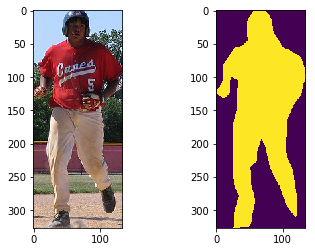

----------------------------------------
Rank: 1, iou: 0.61


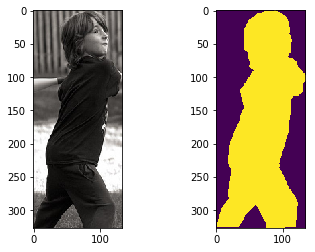

----------------------------------------
Rank: 2, iou: 0.56


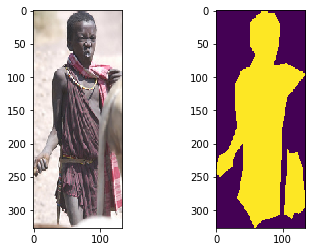

----------------------------------------
Rank: 3, iou: 0.50


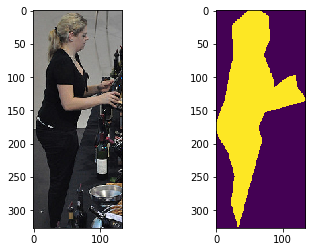

----------------------------------------
Rank: 4, iou: 0.48


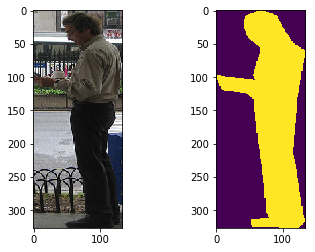

----------------------------------------
Rank: 5, iou: 0.46


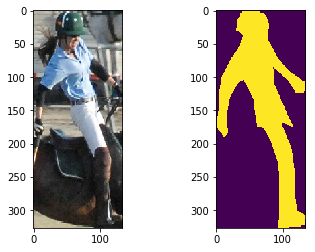

----------------------------------------
Rank: 6, iou: 0.45


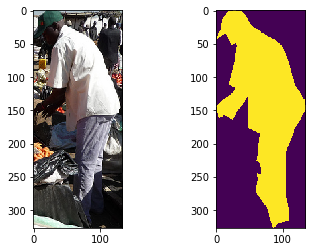

----------------------------------------
Rank: 7, iou: 0.43


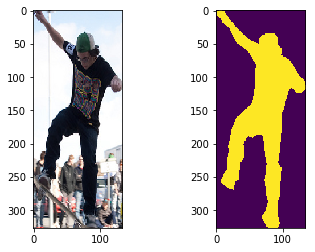

----------------------------------------
Rank: 8, iou: 0.40


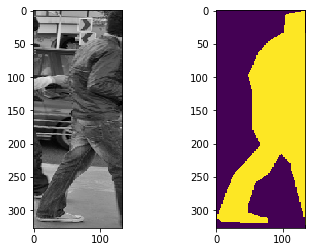

----------------------------------------


In [8]:
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds);
imgIds = imgIds[:100]

imgId, personId = 465702, 0
matches, ref_img, ref_mask = get_max_iou(imgId, personId, imgIds, 1000)

print 'Reference person:'
show_im_and_mask(ref_img, ref_mask)
print '-' * 40

for idx, match in enumerate(matches):
    print 'Rank: %d, iou: %.2f' % (idx + 1, match['iou'])
    show_im_and_mask(match['img'], match['mask'])
    print '-' * 40